In [2]:
 # Versions of FAST used
import fast_curator
import fast_carpenter
import fast_flow

print("curator: ", fast_curator.__version__)
print("carpenter: ", fast_carpenter.__version__)
print("flow: ", fast_flow.__version__)

curator:  0.4.1
carpenter:  0.17.5
flow:  0.4.0


In [3]:
import numpy as np
from fast_curator.write import prepare_file_list, prepare_contents, write_yaml
from fast_curator.read import get_datasets, from_yaml
import fast_flow.v1 as fast_flow
import copy

In [4]:
fileLoc="/global/cfs/cdirs//lz/data/MDC3/background/LZAP-4.7.0/20180430/lz_20180430000_lzap.root"
fileList = prepare_file_list(fileLoc,
                             dataset="WIMP",
                             expand_files="local",
                             tree_name="Scatters",
                             eventtype="mc",
                             no_empty_files=True,
                             confirm_tree=False,
                             ignore_inaccessible=True
                            ) 

datalist = []
datalist.append(fileList)
contents = prepare_contents(datalist)
dataSets = get_datasets(contents)

In [5]:
%load_ext jinja_yaml_magic
%reload_ext jinja_yaml_magic

In [6]:
%%yaml processing_sequence

stages:
    - make_vars: fast_carpenter.Define
    - isSS: fast_carpenter.SelectPhaseSpace
    - fid_z: fast_carpenter.SelectPhaseSpace
    - fid_r: fast_carpenter.SelectPhaseSpace
    - skindome: fast_carpenter.SelectPhaseSpace
    - skinbarrel: fast_carpenter.SelectPhaseSpace
    - isod: fast_carpenter.SelectPhaseSpace
    - heroi: fast_carpenter.SelectPhaseSpace
    - wimproi: fast_carpenter.SelectPhaseSpace
    - more_vars: fast_carpenter.Define
    - binnedDF: fast_carpenter.BinnedDataframe

# Extract RQs
make_vars:
    variables:
        - s1c: {formula: ss.correctedS1Area_phd}
        - logs2c: {formula: log10(ss.correctedS2Area_phd)}
        - r2: {formula: sqrt(ss.x_cm**2 + ss.y_cm**2)}   
        - R2: {formula: sqrt(ss.correctedX_cm**2 + ss.correctedY_cm**2)} 
        - zc: {formula: ss.correctedZ_cm}
        - nscat: {formula: ss.nSingleScatters}
        - sda: {formula: ss.skinDomeArea}   
        - sba: {formula: ss.skinBarrelArea}
        - od: {formula: ss.odPromptArea}
            
# the cuts
isSS:
    region_name: SS
    selection:
        All:
            - nscat > 0
            
fid_z:
    region_name: FIDZ
    selection:
        All:
            - SS
            - 2.0 < zc
            - zc < 132.6
fid_r:
    region_name: FIDR
    selection:
        All:
            - FIDZ
            - R2 <= 68.8
skindome:
    region_name: SkinDome
    selection:
        All:
            - FIDR
            - sda <= 5.0
skinbarrel:
    region_name: SkinBarrel
    selection:
        All:
            - SkinDome
            - sba <= 5.0
isod:
    region_name: OD
    selection:
        All:
            - SkinBarrel
            - od <= 10.0
heroi:
    region_name: HEROI
    selection:
        All:
            - OD
            - s1c <= 1000.0
wimproi:
    region_name: WIMPROI
    selection:
        All:
            - HEROI
            - s1c <= 80.0

more_vars:
    variables:
        - s1c_short: {formula: s1c}
        - s1c_mid: {formula: s1c}

# Binned Dataframe
binnedDF:
    binning:
        - {in: s1c, bins: {low: 1.e0, high: 1.e6, nbins: 500}}
        - {in: s1c_mid, bins: {low: 0, high: 500, nbins: 500}}        
        - {in: s1c_short, bins: {low: 0, high: 100, nbins: 100}}
        - {in: logs2c, bins: {low: log10(1.e1), high: log10(1.e8), nbins: 500}}  
    pad_missing: false
    observed: true
    weights: [SS, FIDZ,FIDR,SkinDome,SkinBarrel,OD,HEROI,WIMPROI]

In [7]:
# Save processing sequence incase you want to run outside of carpenter
import yaml
out_dir = "./comp"
processing_sequence["general"] = {}
processing_sequence["general"]["output_dir"] = out_dir
outfile_name = out_dir + './comp/processing_sequence.yaml'

In [8]:
## As running local, need to define it here too
from fast_carpenter.backends import get_backend
backend = get_backend("coffea:local")

out_dir = "./comp"
class carpenter_args():
    ncores = 30
    outdir = out_dir
    quiet = False
    mode = "local"
    nblocks_per_dataset = -1
    nblocks_per_sample = -1
    blocksize = 50000
    profile = False
    
read_filelist = False
read_processing = False

In [71]:
import fast_flow.v1 as fast_flow
import copy

sequence = fast_flow.read_sequence_dict(**processing_sequence)
WIMP_results = backend.execute(sequence, dataSets, carpenter_args())

In [9]:
import numpy as np
import pandas as pd
import glob
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import fast_plotter.utils as fast_utils
from tabulate import tabulate

In [10]:
def read_data(csv_name):
    data = fast_utils.read_binned_df(csv_name)
    return fast_utils.convert_intervals(data).reset_index().fillna(0) 


# Get list of csvs of interest -> BinnedDataFrames
csvfiles = glob.glob("./comp/tbl_dataset*csv")[0]
# put in order of cuts

In [11]:
def drawSimpleFID(ax, units='cm'):
    r_min = 0.; r_max = 68.8 ** 2; z_min = 0.2; z_max = 132.6
    ax.plot([r_max, r_max], [z_min, z_max], 'k--')
    ax.plot([r_min, r_max], [z_min, z_min], 'k--')
    ax.plot([r_min, r_max], [z_max, z_max], 'k--')
    
def getBins(variable):
    thelist = processing_sequence['binnedDF']['binning'] 
    thedict = next(item for item in thelist if item["in"] == variable)
    
    low = str(thedict['bins']['low']);
    if 'log' in low:
        start = low.find('('); end = low.find(')')
        low = np.log10(float(low[start+1:end]))
    else:
        low = float(low)
    high = str(thedict['bins']['high'])
    if 'log' in high:
        start = high.find('('); end = high.find(')')
        high = np.log10(float(high[start+1:end]))
    else:
        high = float(high)
    nbins = str(thedict['bins']['nbins'])
    if 'log' in nbins:
        start = nbins.find('('); end = nbins.find(')')
        nbins = np.log10(float(nbins[start+1:end]))
    else:
        nbins = float(nbins)
    thebins = np.arange(low, high, (high - low) / nbins)
    return thebins
    
def findLostEvents2D(df, x, y, n):
    outbins = df.loc[(df[x] == -np.inf) | (df[x] == np.inf) | 
                           (df[y] == -np.inf) | (df[y] == np.inf)]
    totevents = df[n].sum()
    # Rows
    # Top
    top = [outbins.loc[  (outbins[x] == -np.inf) 
                        & (outbins[y] == np.inf)][n].sum()]
    top.append(outbins.loc[  (outbins[y] == np.inf) 
                            & (outbins[x] != -np.inf)
                            & (outbins[x] != np.inf)][n].sum())
    top.append(outbins.loc[  (outbins[x] == np.inf) 
                            & (outbins[y] == np.inf)][n].sum())
    # Middle  
    mid = [outbins.loc[  (outbins[x] == -np.inf) 
                       & (outbins[y] != -np.inf)
                       & (outbins[y] != np.inf)][n].sum()]
    mid.append(totevents - outbins[n].sum())
    mid.append(outbins.loc[  (outbins[x] == np.inf)
                           & (outbins[y] != -np.inf)
                           & (outbins[y] != np.inf)][n].sum())
    # Bottom
    bot = [outbins.loc[  (outbins[x] == -np.inf)
                       & (outbins[y] == -np.inf)][n].sum()]
    bot.append(outbins.loc[  (outbins[y] == -np.inf)
                           & (outbins[x] != -np.inf)
                           & (outbins[x] != np.inf)][n].sum())
    bot.append(outbins.loc[  (outbins[x] == np.inf) 
                           & (outbins[y] == -np.inf)][n].sum())
    
    return [top, mid, bot]
    
def get2dhistinfo(table, entries):  
    text = 'Entries:' + str(entries) + '\n' 
    text += 'Entry Distribution\n'
    max_length = len(str(max(max(table))))
    for row in table:
        text += '+' + max_length*'-' + '+' + max_length*'-' + '+' + max_length*'-' + '+\n|' 
        for entry in row:
            text += str(entry).center(max_length, ' ') + '|'
        text += '\n'
    text += '+' + max_length*'-' + '+' + max_length*'-' + '+' + max_length*'-' + '+' 
    return text

def format2dplottable(table, entries):
    rtab = [['N Events:',str(entries),' '],[' ','Distribution',' ']]
    for row in table:
        rtab.append(row)
    return rtab
    
def make2dhistplot(df, x_name, y_name, n_name, title, hist_info=True,info_on_plot=True, xlim=[], ylim=[]):
    
    df1 = df.replace([-np.inf, np.inf], np.nan).dropna()
    x = df1[x_name].to_numpy()
    y = df1[y_name].to_numpy()   
    n = df1[n_name].to_numpy()
    
    table = findLostEvents2D(df, x_name, y_name, n_name)
    plot_info = get2dhistinfo(table, df[n_name].sum())
        
    if hist_info:
        print(plot_info)
    
    xbins = getBins(x_name)
    ybins = getBins(y_name)
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt.hist2d(x, y, bins=[xbins, ybins], weights=n, cmin=1)
    if np.size(xlim) > 0:
        ax.set_xlim(xlim)
    if np.size(ylim):
        ax.set_ylim(ylim)
    if info_on_plot:
        table = format2dplottable(table, df[n_name].sum())
        ax.table(cellText=table,
                 colWidths = [0.1]*3,
                 cellLoc='center',
                 loc='upper right')
    ax.set_ylabel(y_name)
    ax.set_xlabel(x_name)
    ax.set_title(title)
    plt.colorbar()
    
    return fig

def make1dhistplot(df, x_name, n_name, title, xlim=[]):
     
    df1 = df.replace([-np.inf, np.inf], np.nan).dropna()
    x = df1[x_name].to_numpy()
    n = df1[n_name].to_numpy()
    
    print("Plot info",
          "\nTotal Events:", df[n_name].sum(),
          "\nEvents Here:", n.sum()
          )
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt.plot(x, n)
    if np.size(xlim) > 0:
        ax.set_xlim(xlim)
    ax.set_xlabel(x_name)
    ax.set_title(title)
    
    return fig, ax

In [12]:
 print(csvfiles)
df = read_data(csvfiles)

./comp/tbl_dataset.s1c.s1c_mid.s1c_short.logs2c--binnedDF.csv


In [13]:
def dfInfo(yaml):
    thelist = yaml['binnedDF']['binning'] 
    xy_vars = []; n_vars = []
    for item in thelist:
        xy_vars.append(item['in'])
    thelist = yaml['binnedDF']['weights']
    for item in thelist:
        n_vars.append(item)
    n_vars.append('n')
    return xy_vars, n_vars
xy_vars, n_vars = dfInfo(processing_sequence)
print('xy_vars:', xy_vars)
print('n_vars:', n_vars)

xy_vars: ['s1c', 's1c_mid', 's1c_short', 'logs2c']
n_vars: ['SS', 'FIDZ', 'FIDR', 'SkinDome', 'SkinBarrel', 'OD', 'HEROI', 'WIMPROI', 'n']


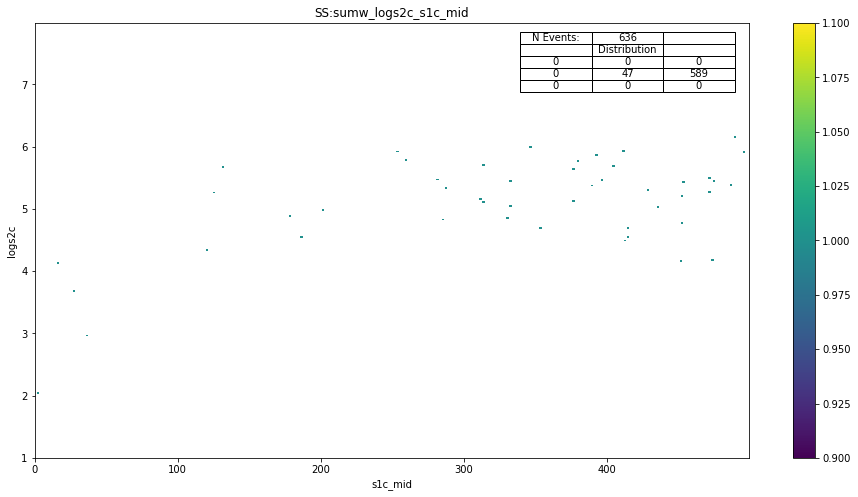

In [20]:
var_x = 's1c_mid'; var_y = 'logs2c'; var_n = 'SS:sumw' #FIDR:sumw2'
df_xy = df.groupby([var_x, var_y])[var_n].sum()
df_xy = df_xy.reset_index()
fig = make2dhistplot(df_xy, var_x, var_y, var_n, title=var_n + '_' + var_y + '_' + var_x, hist_info=False)
plt.show()

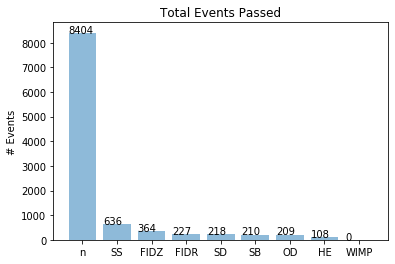

In [17]:
ntotal = df['n'].sum()
SStotal = df['SS:sumw2'].sum()
FidZtotal = df['FIDZ:sumw2'].sum()
FidRtotal = df['FIDR:sumw2'].sum()
SBtotal = df['SkinBarrel:sumw2'].sum()
SDtotal = df['SkinDome:sumw2'].sum()
ODtotal = df['OD:sumw2'].sum()
HEtotal = df['HEROI:sumw2'].sum()
WIMPtotal = df['WIMPROI:sumw2'].sum()
x = ('n','SS','FIDZ','FIDR','SD','SB','OD','HE','WIMP')
xrange = np.arange(len(x))
y = [ntotal,SStotal,FidZtotal,FidRtotal,SDtotal,SBtotal,ODtotal,HEtotal,WIMPtotal]
plt.bar(xrange, y, align='center', alpha=0.5)
plt.xticks(xrange, x)
plt.ylabel('# Events')
plt.title('Total Events Passed')
for i, v in enumerate(y):
    plt.text(xrange[i] - 0.4, v + 0.01, str(v))
plt.show()

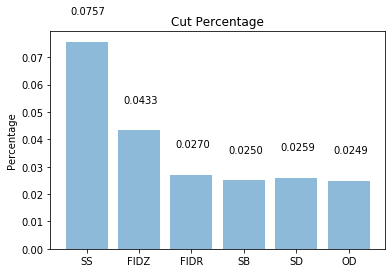

In [16]:
SSeff = SStotal/ntotal
FidZeff = FidZtotal/ntotal
FidReff = FidRtotal/ntotal
SBeff = SBtotal/ntotal
SDeff = SDtotal/ntotal
ODeff = ODtotal/ntotal
x = ('SS','FIDZ','FIDR','SB','SD','OD')
xrange = np.arange(len(x))
y = [SSeff,FidZeff,FidReff,SBeff,SDeff,ODeff]
plt.bar(xrange, y, align='center', alpha=0.5)
plt.xticks(xrange, x)
plt.ylabel('Percentage')
plt.title('Cut Percentage')
for i, v in enumerate(y):
    z = format(v, '.4f')
    plt.text(xrange[i] - 0.3, v + 0.01, str(z))
plt.show()

In [80]:
df_xy

s1c_mid  logs2c  OD:sumw
0       -inf   4.507        0
1        2.5   2.043        0
2       16.5   4.129        0
3       27.5   3.681        0
4       36.5   2.967        0
..       ...     ...      ...
165      inf   6.971        0
166      inf   7.013        0
167      inf   7.041        0
168      inf   7.111        0
169      inf   7.125        0

[170 rows x 3 columns]